<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Training-API" data-toc-modified-id="Training-API-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Training API</a></span><ul class="toc-item"><li><span><a href="#SimpleNet" data-toc-modified-id="SimpleNet-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>SimpleNet</a></span></li></ul></li><li><span><a href="#TrainingPhase" data-toc-modified-id="TrainingPhase-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>TrainingPhase</a></span></li><li><span><a href="#Basic-lr-decay" data-toc-modified-id="Basic-lr-decay-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Basic lr decay</a></span><ul class="toc-item"><li><span><a href="#Stepwise-(constant)" data-toc-modified-id="Stepwise-(constant)-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Stepwise (constant)</a></span></li><li><span><a href="#Linear" data-toc-modified-id="Linear-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Linear</a></span></li><li><span><a href="#Cosine" data-toc-modified-id="Cosine-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Cosine</a></span></li><li><span><a href="#Exponential" data-toc-modified-id="Exponential-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Exponential</a></span></li><li><span><a href="#Polynomial" data-toc-modified-id="Polynomial-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Polynomial</a></span></li></ul></li><li><span><a href="#SGDR" data-toc-modified-id="SGDR-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>SGDR</a></span></li><li><span><a href="#1cycle" data-toc-modified-id="1cycle-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>1cycle</a></span></li><li><span><a href="#With-discriminative-learning-rates." data-toc-modified-id="With-discriminative-learning-rates.-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>With discriminative learning rates.</a></span></li><li><span><a href="#A-customized-LR-Finder" data-toc-modified-id="A-customized-LR-Finder-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>A customized LR Finder</a></span><ul class="toc-item"><li><span><a href="#Change-the-optimizer-at-each-phase" data-toc-modified-id="Change-the-optimizer-at-each-phase-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Change the optimizer at each phase</a></span></li><li><span><a href="#Change-Data-during-training" data-toc-modified-id="Change-Data-during-training-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Change Data during training</a></span></li><li><span><a href="#DAWNBench" data-toc-modified-id="DAWNBench-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>DAWNBench</a></span></li><li><span><a href="#CIFAR-Results" data-toc-modified-id="CIFAR-Results-7.4"><span class="toc-item-num">7.4&nbsp;&nbsp;</span>CIFAR Results</a></span></li></ul></li></ul></div>

# Training API

Forked from [sguggar github](https://github.com/gsgbills/Deep-Learning.git), this
Notebook shows how to use the new `fastai` API, to allow flexibility while training.
- [DL13 Video](https://youtu.be/xXXiC4YRGrQ)
- [DL13 Forum](http://forums.fast.ai/t/lesson-13-discussion-and-wiki/15297/1)

See also [Learning Rate Schedules and Adaptive Learning Rate Methods for Deep Learning](https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1)

In [7]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

All the examples run on cifar10, so change the path to a directory that contains this dataset, with a train and a valid folder, each of them containing ten subdirectories for each class.

In [2]:
from fastai.conv_learner import *
PATH = Path("../data/cifar10/")

In [3]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))

This will allow us to grab data for a given iamge size and batch size.

In [4]:
def get_data(sz,bs):
    tfms = tfms_from_stats(stats, sz, aug_tfms=[RandomFlip()], pad=sz//8)
    return ImageClassifierData.from_paths(PATH, val_name='test', tfms=tfms, bs=bs)

In [5]:
size = 32
batch_size = 64

In [6]:
data = get_data(size,batch_size)

## SimpleNet
Very simple model to train: an ANN with a hidden layer.

In [8]:
def SimpleNet(layers):
    list_layers=[Flatten()]
    for i in range(len(layers)-1):
        list_layers.append(nn.Linear(layers[i], layers[i + 1]))
        if i < len(layers)-2: list_layers.append(nn.ReLU(inplace=True))
        else: list_layers.append(nn.LogSoftmax(dim=0))
    return nn.Sequential(*list_layers)

In [9]:
learn = ConvLearner.from_model_data(SimpleNet([32*32*3, 40,10]), data)

# TrainingPhase
With the new API, you don't use a pre-implemented training schedule but you can design your own with an object called **TrainingPhase**. 
A training phase is a class that will record all the parameters you want to apply during this part of the training loop, specifically:
- a number of **epochs** for which these settings will be valid (can be a float)
- an **optimizer** function (SGD, RMSProp, Adam...)
- a **learning rate** (or array of lrs) or a range of learning rates (or array of lrs) if you want to change the lr.
- a learning rate **decay method** (that will explain how you want to change the lr)
- a **momentum** (which will beta1 if you're using Adam), or a range of momentums if you want to change it
- a **momentum decay method** (that will explain how you want to change the momentum, if applicable)
- optionally a **weight decay** (or array of wds)
- optionally a **beta** parameter (which is the RMSProp alpha or the Adam beta2, if you want another vlaue than default)

By combining those blocks we can implement "any method" of training? 

# Basic lr decay

Let's begin with SGD and momentum, with a learning rate $\mu=e^{-2}$ for 1 epoch 
then $\mu = e^{-3}$ for two epochs. 
We create a list of two phases for this.

In [10]:
phases = [TrainingPhase(epochs=1, opt_fn=optim.SGD, lr = 1e-2), 
          TrainingPhase(epochs=2, opt_fn=optim.SGD, lr = 1e-3)]

NB: `momentum` defaults to 0.9. To have no momentum, add `momentum=0`.

Now we call `fit_opt_sched(phases)`.

There are currently 5 methods of decay:
1. NO (i.e., constant) 
2. linear 
3. cosine 
4. exponential 
5. polynomial. 

## Stepwise (constant)

In [11]:
learn.fit_opt_sched(phases)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      3.630894   4.565808   0.1397    
    1      3.500259   4.50203    0.1435                     
    2      3.482137   4.521681   0.1409                     



[array([4.52168]), 0.1409]

To see what we did, use `learn.sched.plot_lr()`.
Below is an iteration against $\mu$ (learning rate) chart. 
We train for a while at $\mu =$ 0.01 and then $\mu$ = 0.001. 
This chart shows the stepwise approach that most people that trained ImageNet use.
It is **not** good, not in fastai, but useful to replicate existing papers.
(Instead of writing a number of fit, fit, fit calls with different learning rates).

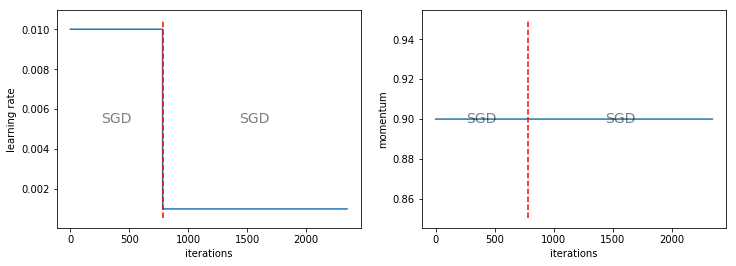

In [12]:
learn.sched.plot_lr()

The red dashed line represent the change of phase. 
The optimizer name, e.g. SGD (plus its optional parameters) is indicated. 
Remove these by `show_text=False`

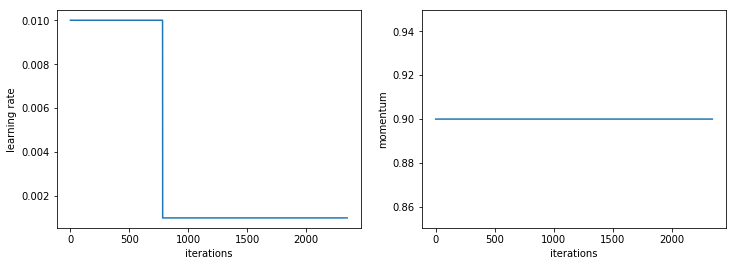

In [13]:
learn.sched.plot_lr(show_text=False)

Here the momentums don't change, so we might want to hide them by `show_moms=False`.

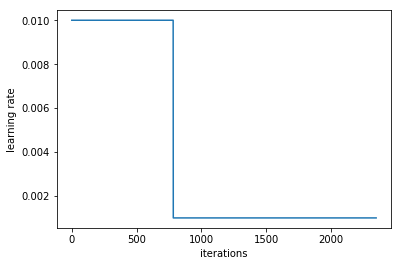

In [14]:
learn.sched.plot_lr(show_text=False, show_moms=False)

Now let's train for 3 epochs with a different rate each:
1. `lr=1e-2` 
2. Linearly Decrease the rate from `1e-2` to `1e-3` 
3. `lr=1e-3`

In [15]:
phases = [TrainingPhase(epochs=1, opt_fn=optim.SGD, lr = 1e-2), 
          TrainingPhase(epochs=1, opt_fn=optim.SGD, lr = (1e-2,1e-3), lr_decay=DecayType.LINEAR),
          TrainingPhase(epochs=1, opt_fn=optim.SGD, lr = 1e-3)]

In [16]:
learn.fit_opt_sched(phases)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      3.583752   4.575428   0.1311    
    1      3.459059   4.537713   0.1418                     
    2      3.471198   4.531489   0.1434                     



[array([4.53149]), 0.1434]

## Linear
Linear is going from a to b with a line, described below were the learning rate $\mu$ at batch $i$ over $n$ is:

$\mu_i = \mu_{start} + (\mu_{end} - \mu_{start}) \times i/n$

In the above example, $\mu_{start} = e^{-2}$ and $\mu_{end} = e^{-3}$.<br>
For example, to compute the value of $\mu_i$ for $i=45, n=6$: 

In [67]:
i, n, start_lr, end_lr = 45, 6, 1e-2, 1e-3
lr_i = start_lr + (end_lr - start_lr) * i/n
lr_i

-0.0575

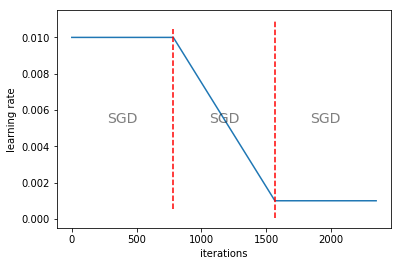

In [21]:
learn.sched.plot_lr(show_moms=False)

This is a better way to train: Explore at higher $\mu$, fine-tune at lower $\mu$, 
and gradually slide between the two.

In [22]:
phases = [TrainingPhase(epochs=1, opt_fn=optim.SGD, lr = 1e-2), 
          TrainingPhase(epochs=1, opt_fn=optim.SGD, lr = (1e-2,1e-3), lr_decay=DecayType.COSINE),
          TrainingPhase(epochs=1, opt_fn=optim.SGD, lr = 1e-3)]

In [23]:
learn.fit_opt_sched(phases)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      3.589111   4.596723   0.131     
    1      3.432569   4.53047    0.1404                     
    2      3.426079   4.538905   0.1423                     



[array([4.5389]), 0.1423]

## Cosine
A very useful $\mu$ annealing shape.
Cosine is going from a to b following half a cosine. 
The formula for $\mu$ at batch i over n is:
$\mu_i = \mu_{end} + (\mu_{start} - \mu_{end}) / 2 \times ( 1 + cos (i\pi) \div n)$

In [ ]:
lr_i = end_lr + (start_lr - end_lr)/2 * ( 1 +  np.cos( i * np.pi) / n )

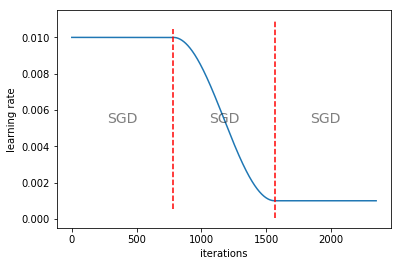

In [24]:
learn.sched.plot_lr(show_moms=False)

In [25]:
phases = [TrainingPhase(epochs=1, opt_fn=optim.SGD, lr = 1e-2), 
          TrainingPhase(epochs=1, opt_fn=optim.SGD, lr = (1e-2,1e-3), lr_decay=DecayType.EXPONENTIAL),
          TrainingPhase(epochs=1, opt_fn=optim.SGD, lr = 1e-3)]

In [26]:
learn.fit_opt_sched(phases)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      3.54377    4.641551   0.1378    
    1      3.431923   4.53771    0.1412                     
    2      3.395952   4.543388   0.1376                     



[array([4.54339]), 0.1376]

## Exponential
Very popular approach.
Exponential is multiplying $\mu$ by the samething at each step, this thing being computed to be exactly what's needed to go from our start point to our end point. 
$\mu$ batch i over n is:
$\mu_i = \mu_{start} \times (\mu_{end} \div \mu_{start})^{i/n}$

In [ ]:
lr_i = start_lr * (end_lr/start_lr)**(i/n)

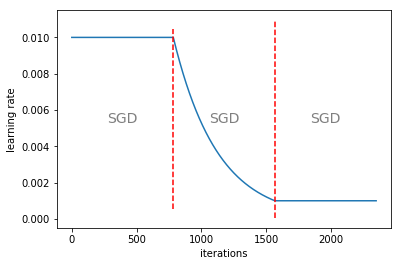

In [27]:
learn.sched.plot_lr(show_moms=False)

In [28]:
phases = [TrainingPhase(epochs=1, opt_fn=optim.SGD, lr = 1e-2), 
          TrainingPhase(epochs=1, opt_fn=optim.SGD, lr = (1e-2,1e-3), lr_decay=(DecayType.POLYNOMIAL, 2)),
          TrainingPhase(epochs=1, opt_fn=optim.SGD, lr = 1e-3)]

In [29]:
learn.fit_opt_sched(phases)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      3.543259   4.634571   0.1412    
    1      3.437938   4.542204   0.145                      
    2      3.40265    4.550887   0.1435                     



[array([4.55089]), 0.1435]

## Polynomial
**NB: Polynomial works best but seems to be largely ignored.**
The POLYNOMIAL decay type needs a second argument, `p`: the value of the power in the polynomial decay. 
Per JH, `p=0.9` gives good results.<br>
The formula that gives the update is:

$\mu_i = \mu_{end} + (\mu_{start} - \mu_{end}) \times (1 - i/n)^{p}$

In [ ]:
lr_i = end_lr + (start_lr - end_lr) * (1 - i/n) ** p

Below, for `p = 2`.

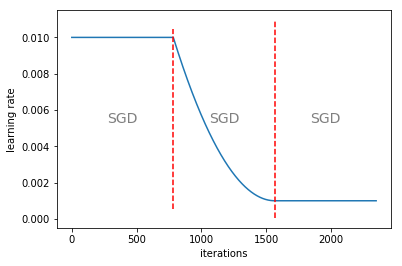

In [30]:
learn.sched.plot_lr(show_moms=False)

In [31]:
phases = [TrainingPhase(epochs=1, opt_fn=optim.SGD, lr = 1e-2), 
          TrainingPhase(epochs=1, opt_fn=optim.SGD, lr = (1e-2,1e-3), lr_decay=(DecayType.POLYNOMIAL, 0.5)),
          TrainingPhase(epochs=1, opt_fn=optim.SGD, lr = 1e-3)]

In [32]:
learn.fit_opt_sched(phases)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      3.573435   4.642784   0.1349    
    1      3.45217    4.538537   0.1394                     
    2      3.396768   4.547016   0.1417                     



[array([4.54702]), 0.1417]

And here `p = 0.5`. In general, the greater p is, the more 'exponential' your curve will look (p=2 wasn't very different from exponential already). 
p=1 is simply linear (and close values will give something close to a line). 
Lower values of p (close to 0) will give a curve that stays up a bit longer before going down.


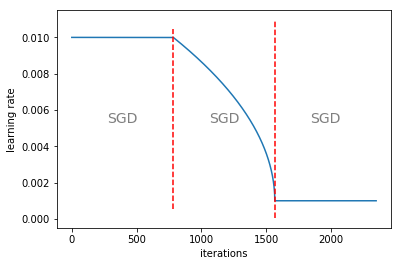

In [33]:
learn.sched.plot_lr(show_moms=False)

If we don't specify an end value, it will be assumed the value given is the starting value and the end value is 0. 
This doesn't work for the EXPONENTIAL type of decay.

In [34]:
phases = [TrainingPhase(epochs=1, opt_fn=optim.SGD, lr = 1e-2), 
          TrainingPhase(epochs=1, opt_fn=optim.SGD, lr = 1e-2, lr_decay=DecayType.COSINE),
          TrainingPhase(epochs=1, opt_fn=optim.SGD, lr = 1e-3)]

In [35]:
learn.fit_opt_sched(phases)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      3.574101   4.617181   0.1386    
    1      3.423038   4.538467   0.1438                     
    2      3.420221   4.544497   0.1413                     



[array([4.5445]), 0.1413]

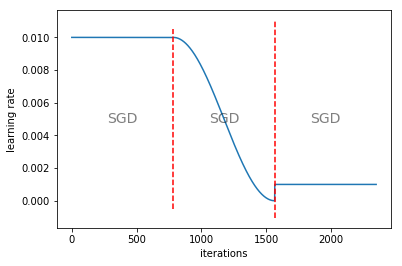

In [36]:
learn.sched.plot_lr(show_moms=False)

As seen above, the the next cycle can start at a different point.<br>
All the decays are implemented in `sgdr.py` in the function `next_val` of the class `DecayScheduler`. <br>
To add a new decays:
   - adding it in the DecayType class
   - implementing the new formula in the function next_val.

# SGDR

The traditional Stochastic Gradient with Restart we used requires three arguments:
- the number of cycles
- the length of a cycle (cycle_len)
- the value by wich we should multiply the cycle_len after each cycle (cycle_mult)

Also, note there is a warm-up at constant lr of 1/100th of the max value during 1/20th of the first cycle.

This is implemented in `phases_sgdr()` which creates a list of `phases` (number of cycles + 1 here). 
Remember you can have a float number for the epochs in a Training Phase.

In [37]:
def phases_sgdr(lr, opt_fn, num_cycle,cycle_len,cycle_mult):
    phases = [TrainingPhase(epochs = cycle_len/ 20, opt_fn=opt_fn, lr=lr/100),
              TrainingPhase(epochs = cycle_len * 19/20, opt_fn=opt_fn, lr=lr, lr_decay=DecayType.COSINE)]
    for i in range(1,num_cycle):
        phases.append(TrainingPhase(epochs = cycle_len * (cycle_mult**i), opt_fn=opt_fn, lr=lr, lr_decay=DecayType.COSINE))
    return phases

In [38]:
learn.fit_opt_sched(phases_sgdr(1e-2, optim.Adam, 2, 1, 2))

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      3.541247   4.510374   0.1406    
    1      3.791065   4.614112   0.1192                     
    2      3.525679   4.500684   0.1392                     



[array([4.50068]), 0.1392]

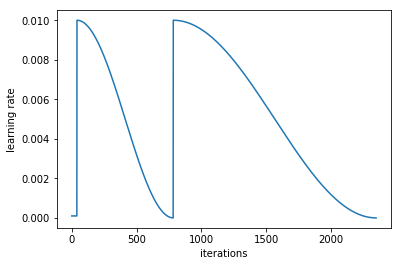

In [39]:
learn.sched.plot_lr(show_text=False,show_moms=False)

Looks familiar? :)
He’s even done the little trick of training at low $\mu$ just for a little bit and then pop up and do a few cycles, and the cycles are increasing in length [8:05]. 
All done in a single function.

# 1cycle

[Leslie Smith's 1cycle policy](https://sgugger.github.io/the-1cycle-policy.html) states to 
- pick a maximum $\mu_{max}$ with traditional learning rate finder.
- Choose a factor $div$ so that $\mu_{min} = \mu_{max} \div div$.
- Then do 2 phases of equal length:
    - going linearly from $\mu_{min}$ to $\mu_{max}$, 
    - then back to $\mu_{min}$.

In parallel, the momentum $p$ should begin high (e.g., $p_{max}=0.95$) 
and decrease to a minimum (e.g., $p_{min} =0.85$) as $\mu$ grows, 
then returns to $p_{max}$ as $\mu$ decreases.

To complete this cycle, allow a bit of time to let $\mu$ decrease even more at the end.
Here linearly from $\mu_{min}$ to $mu_{min} \times 10^{-2}$ since it seemed to work best in experiments.

Let's create a function 1cycle that takes the arguments:
- `cycle_len`: the total length of the cycle (in epochs)
- `lr`: the maximum learning rate $\mu_{max}$
- `div`: by how much do we want to divide $\mu_{max}$
- `pct`: what percentage of epochs should be left at the end for the final annealing
- `max_mom`: the maximum momentum $p_{max}$
- `min_mom`: the minimum momentum $p_{min}$

The optim function should be SGD (with momentum).

In [40]:
def phases_1cycle(cycle_len,lr,div,pct,max_mom,min_mom):
    tri_cyc = (1-pct/100) * cycle_len
    return [TrainingPhase(epochs=tri_cyc/2, opt_fn=optim.SGD, lr=(lr/div,lr), lr_decay=DecayType.LINEAR, 
                          momentum=(max_mom,min_mom), momentum_decay=DecayType.LINEAR),
           TrainingPhase(epochs=tri_cyc/2, opt_fn=optim.SGD, lr=(lr,lr/div), lr_decay=DecayType.LINEAR, 
                          momentum=(min_mom,max_mom), momentum_decay=DecayType.LINEAR),
           TrainingPhase(epochs=cycle_len-tri_cyc, opt_fn=optim.SGD, lr=(lr/div,lr/(100*div)), lr_decay=DecayType.LINEAR, 
                          momentum=max_mom)]

In [41]:
learn.fit_opt_sched(phases_1cycle(3, 1e-2, 10, 10, 0.95, 0.85))

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      3.890957   4.749238   0.1292    
    1      3.810869   4.70689    0.1267                     
    2      3.587783   4.516609   0.1326                     



[array([4.51661]), 0.1326]

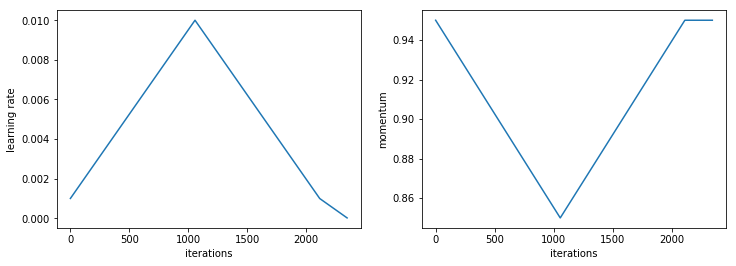

In [42]:
learn.sched.plot_lr(show_text=False)

Now we can test different types of annealing at the end of the 1cycle.
So if we fit with that, we get this triangle followed by a little flatter bit.
Notice that the momentum has a momentum decay. 
And in the third TrainingPhase, we have a fixed momentum. 
So it’s doing the momentum and the learning rate at the same time.

# With discriminative learning rates.

When you unfreeze a pretrained model, you often use discriminative learning rates, and this works with this new API too. 
Just pass an array or a list of discriminative learning rates instead of a single value.
Interesting is to use the combination of discriminative learning rates and 1cycle. 

In [43]:
learn = ConvLearner.pretrained(resnet34, data, metrics=[accuracy])

In [44]:
learn.unfreeze()
lr = 1e-2
lrs = np.array([lr/100,lr/10,lr])

In [45]:
phases = [TrainingPhase(epochs=1, opt_fn=optim.Adam, lr=(lrs/10,lrs), lr_decay=DecayType.LINEAR),
          TrainingPhase(epochs=2, opt_fn=optim.Adam, lr=lrs, lr_decay=DecayType.COSINE)]

In [46]:
learn.fit_opt_sched(phases)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.907855   0.750745   0.7482    
    1      0.651225   0.545657   0.8146                      
    2      0.512256   0.464539   0.8356                      



[array([0.46454]), 0.8356]

What is plotted in these cases is the highest learning rate.

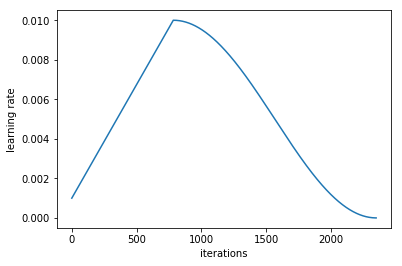

In [47]:
learn.sched.plot_lr(show_text=False, show_moms=False)

# A customized LR Finder

This API can also be used to run a learning rate finder: 
- put a very low starting $\mu$ and a very large ending $\mu$.
- choose exponential or linear decay. 
- To stop when the loss goes "wild", we add the option `stop_div= True`. 
This can also be used in a regular fit if you want to stop the training 
in case the loss suddenly spikes.

As you can choose the number of epochs, this is particularly useful:
- when you have a small dataset (run more epochs to have a clearer curve) or 
- a very large one where a fraction of an epoch is plenty. 
In general 100-200 values are plenty to have a clear curve.
Since we have 782 batches on cifar10, we'll run this customized LR Finder on 0.25 epochs.

In [48]:
phases = [TrainingPhase(epochs=0.25, opt_fn=optim.SGD, lr=(1e-5,10), 
                        lr_decay=DecayType.EXPONENTIAL,momentum=0.9)]

In [49]:
learn = ConvLearner.from_model_data(SimpleNet([32*32*3, 40,10]), data)

**NB:** Save your model before fitting as the LR Finder will alter it.

In [50]:
learn.save('tmp')
learn.fit_opt_sched(phases, stop_div=True)
learn.load('tmp')

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 18%|█▊        | 142/782 [00:02<00:13, 47.53it/s, loss=16.4]


Then we can draw the curve with the usual command:

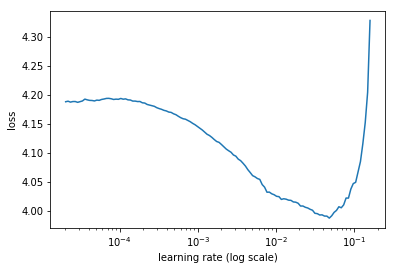

In [51]:
learn.sched.plot()

If you choose a linear decay, the curve will be plotted without using a log scale for the learning rates. 
**NB:** Be careful than we you use a linear scale for the lrs, you get very fast to the high ones so you can't put as wide a range.

In [52]:
phases = [TrainingPhase(epochs=0.25, opt_fn=optim.SGD, lr=(0.001,0.1), 
                        lr_decay=DecayType.LINEAR,momentum=0.9)]
learn.save('tmp')
learn.fit_opt_sched(phases, stop_div=True)
learn.load('tmp')

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 19%|█▊        | 145/782 [00:03<00:13, 46.36it/s, loss=17.8]


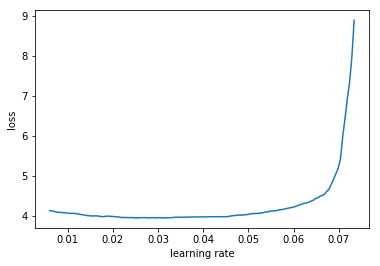

In [53]:
learn.sched.plot()

You can always force the scale to be linear (or log scale) by using the optional argument `linear=True` in the plot function.

In [54]:
phases = [TrainingPhase(epochs=0.25, opt_fn=optim.SGD, lr=(1e-5,10), 
                        lr_decay=DecayType.EXPONENTIAL,momentum=0.9)]
learn.save('tmp')
learn.fit_opt_sched(phases, stop_div=True)
learn.load('tmp')

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 18%|█▊        | 137/782 [00:03<00:14, 45.32it/s, loss=20.1]


One useful thing is the linear parameter to the plot function. 
If you use linear schedule rather than an exponential schedule in your learning rate finder (which is a good idea if you fine-tuned into roughly the right area), 
then you can use linear to find exactly the right area. 
Then you probably want to plot it with a linear scale. 
So that’s why you can also pass linear to plot.

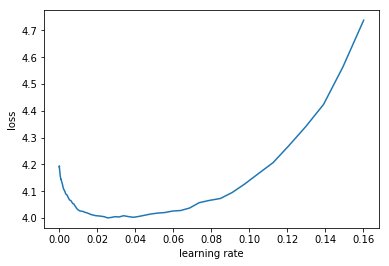

In [55]:
learn.sched.plot(linear=True)

# Change the optimizer at each phase
You can change the optimizer each phase [11:06]. 
That’s important.
**NB:** state-of-the-art for training on large batch sizes quickly for ImageNet starts with RMSProp first part, then they switch to SGD for the second bit. 
So that could be something interesting to experiment more with because at least one paper has now shown that that can work well. 
For instance, we can do a 1cycle with SGD and cyclical momentum but then anneal with Adam.

In [56]:
phases = [TrainingPhase(epochs=1, opt_fn=optim.SGD, lr=(1e-3,1e-2), lr_decay=DecayType.LINEAR, 
                          momentum=(0.95,0.85), momentum_decay=DecayType.LINEAR),
           TrainingPhase(epochs=1, opt_fn=optim.SGD, lr=(1e-2,1e-3), lr_decay=DecayType.LINEAR, 
                          momentum=(0.85,0.95), momentum_decay=DecayType.LINEAR),
           TrainingPhase(epochs=1, opt_fn=optim.Adam, lr=1e-3, lr_decay=DecayType.COSINE, momentum=0.9)]

In [57]:
learn.fit_opt_sched(phases)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      3.604035   4.538336   0.1386    
    1      3.528066   4.494687   0.1412                     
    2      3.475345   4.510874   0.1441                     



[array([4.51087]), 0.1441]

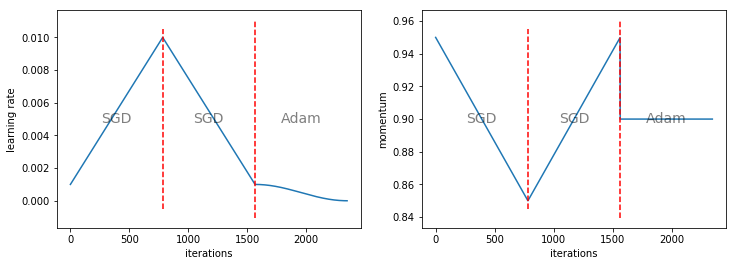

In [58]:
learn.sched.plot_lr()

# Change Data during training
Why would we want to change our data? 
Because we could use small images at the start and bigger images later. 
Would train the first bit more quickly with smaller images.
If we halve the height and halve the width, you’ve got 1/4 of the activations every layer, so it is a lot faster. 
It might even generalize better. 
So you can now create a couple of different sizes, for example, for CIFAR-10 28 and then 32 sized images. 
Then if we pass an array of data in the `data_list` parameter when we call `fit_opt_sched`, it’ll use different dataset for each phase.

This is only applicable for a full CNN that can works with any size, but you could decide to train it for a bit with a smaller size before increasing it. 

In [59]:
def ConvBN(n_in, n_out, stride):
    return nn.Sequential(nn.Conv2d(n_in,n_out,3,stride=stride,padding=1), nn.BatchNorm2d(n_out))

In [60]:
def ShallowConvNet():
    listlayers = [ConvBN(3,64,20), nn.ReLU(inplace=True), ConvBN(64,128,2), nn.ReLU(inplace=True),
                  nn.AdaptiveAvgPool2d(1), Flatten(), nn.Linear(128,10), nn.LogSoftmax(dim=0)]
    return nn.Sequential(*listlayers)

Let's grab the data for two different sizes.

In [61]:
data1 = get_data(28,batch_size)
data2 = get_data(32,batch_size)

And create a learner object.

In [62]:
learn = ConvLearner.from_model_data(ShallowConvNet(), data1)

And let's say we want to phases of cos anneal with Adam, but want to train on the size 28 for the first, then on the size 32.

In [63]:
phases = [TrainingPhase(epochs=1, opt_fn=optim.Adam, lr=1e-2, lr_decay=DecayType.COSINE),
          TrainingPhase(epochs=2, opt_fn=optim.Adam, lr=1e-2, lr_decay=DecayType.COSINE)]

Pass a list of data in the arguments of `fit_opt_sched()`. 
NB: this list must have the same size as phases! 
If the same data object should be used through multiple phases, repeat it as needed.

In [64]:
learn.fit_opt_sched(phases, data_list=[data1,data2])

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      3.659141   4.418743   0.1541    
    1      3.624726   4.45123    0.1526                     
    2      3.599374   4.424285   0.1462                     



[array([4.42428]), 0.1462]

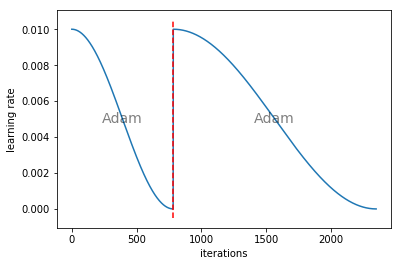

In [65]:
learn.sched.plot_lr(show_moms=False)

## DAWNBench 
Change data during training was used for DAWN bench entries, i.e., increase the size with very little code. [13:02]? 
The results in DAWNBench training on ImageNet:

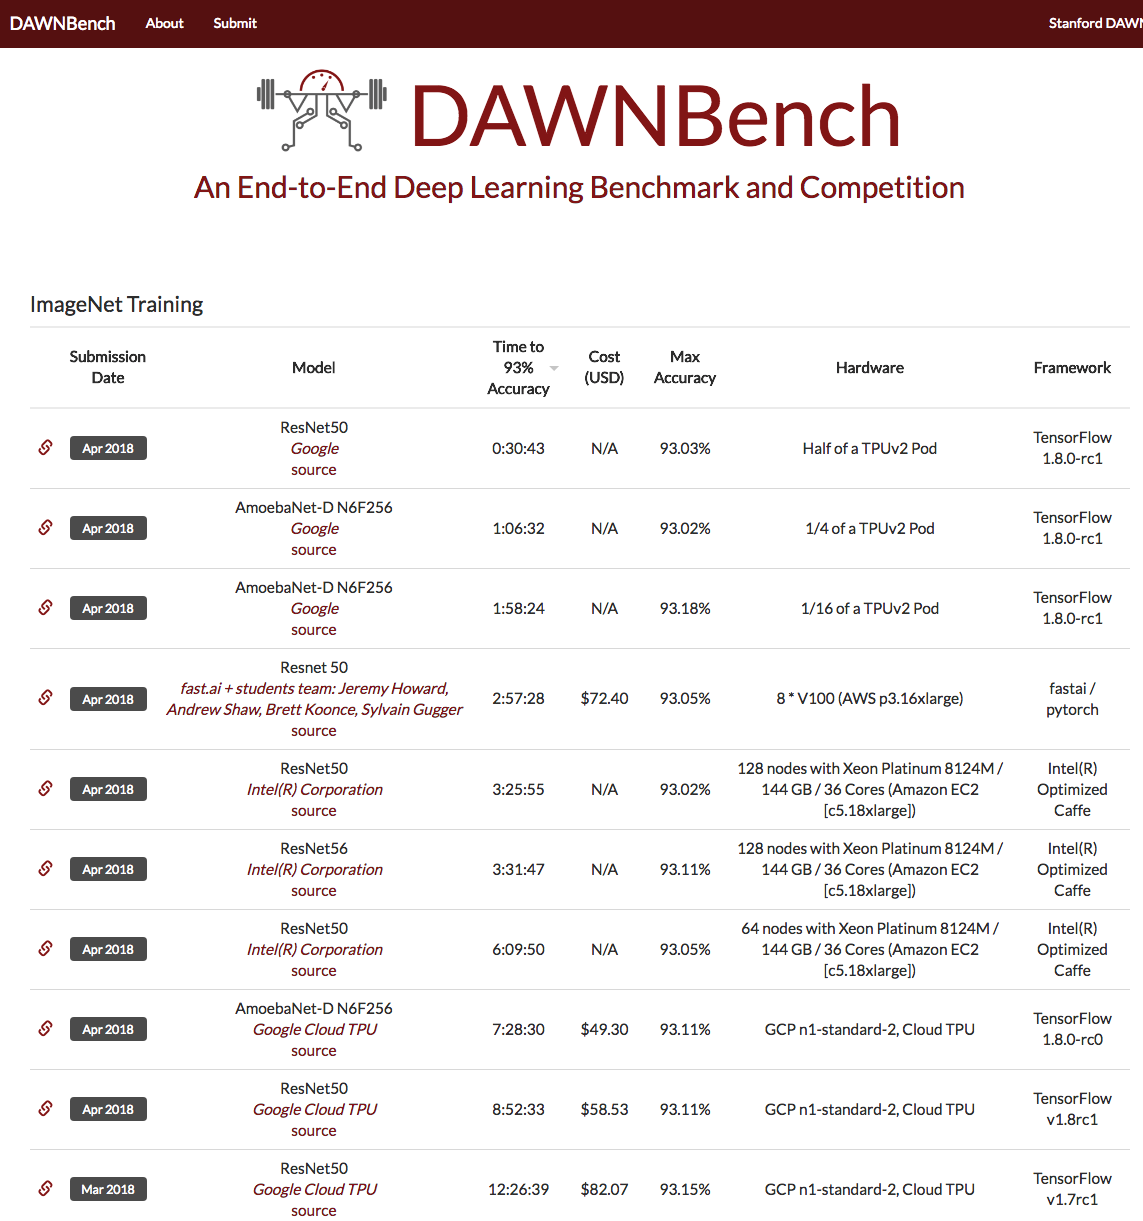

Google won this with 30' on a cluster of TPUs. 
fastai has the best non-cluster of TPU result, under 3 hours on a single node with 8 V100 GPUs.
It beat Intel on 128 nodes. 
They also beat Google running on a TPU.
Using this approach, we’ve shown:
- the fastest GPU result
- the fastest single machine result
- the fastest publicly available infrastructure result

TPU pods only Google has. 
The cost is tiny ($72.54), this Intel one costs them $1,200 worth of compute — they haven’t even written it here, but that’s what you get if you use 128 computers in parallel each one with 36 cores, each one with 140G compare to our single AWS instance. 
So this is kind of a breakthrough in what we can do. 

Fastai trained ImageNet on a single publicly available machine and this is $72, 
it was actually $25 because we used a spot instance. 
(Andrew Shaw built this whole system to allow us to throw a whole bunch of spot instance experiments up and run them simultaneously and pretty much automatically, but DAWN bench doesn’t quote the actual number we used. So it’s actually $25, not $72.)

**NB: The `data_list` idea is super important and helpful.**

## CIFAR Results
The CIFAR10 results are also there.
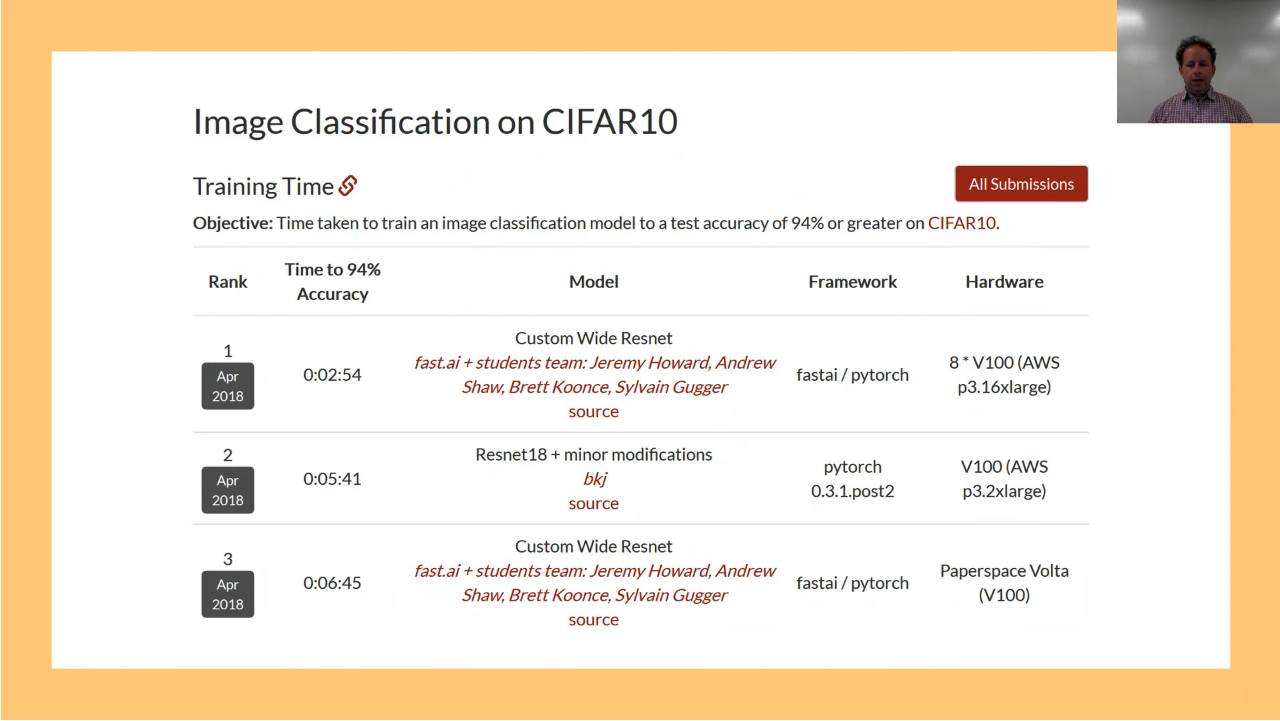
The previous best was over an hour. 
The trick here was using 1cycle.
The training phase API was used to get these top results. <br>
Another student (bkj) took Resnet18 and added concat pooling, and 1cycle.

Same for cost — the top 3 are in Paperspace. 
Brett ran this on Paperspace and got the cheapest result just ahead of bkj.

[16:25], 
Opportunities for the training stuff more quickly and cheaply are about learning rate annealing, size annealing, and training with different parameters at different times.
We may go a lot faster and cheaper, helpful for people in resource constrained environments. 